# Split the dataset into train and validation 

In [89]:
import pandas as pd

In [90]:
data_frame = pd.read_csv('../datasets/text.csv')

In [91]:
data_frame.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


* Note: 0 = sad, 1 = joy, 2 = love, 3 = anger, 4 = fear, 5 = suprise

In [92]:
data_frame.tail()

,Unnamed: 0,text,label
416804,416804,i feel like telling these horny devils to find...,2
416805,416805,i began to realize that when i was feeling agi...,3
416806,416806,i feel very curious be why previous early dawn...,5
416807,416807,i feel that becuase of the tyranical nature of...,3
416808,416808,i think that after i had spent some time inves...,5


In [93]:
del data_frame["Unnamed: 0"]

In [94]:
data_frame.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


Before spliting dataset, we need to check the distribution of the 'label' column

In [95]:
data_frame.label.value_counts()

label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64

In [96]:
from sklearn.model_selection import train_test_split

In [97]:
test_size = 0.2
train_df, validation_df = train_test_split(data_frame, test_size=test_size, stratify=data_frame.label, random_state=42)

In [98]:
train_df.label.value_counts()

label
1    112853
0     96949
3     45854
4     38170
2     27643
5     11978
Name: count, dtype: int64

To check if the data splits have similar distribution, we multiply the value counts of validation_df to 4 (= train size/ validation size)

In [99]:
# Validation (adjusted) value counts
validation_df.label.value_counts() * 4

label
1    112856
0     96952
3     45852
4     38168
2     27644
5     11976
Name: count, dtype: int64

Since the adjusted value counts of validation_df looks very similar to the value counts of train_df, these two data splits have the same class distribution

# Data Exploration

In [100]:
from collections import Counter 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings('ignore')
from wordcloud import WordCloud, STOPWORDS

In [101]:
all_labels = Counter(data_frame.label)
all_labels.most_common()

[(1, 141067), (0, 121187), (3, 57317), (4, 47712), (2, 34554), (5, 14972)]

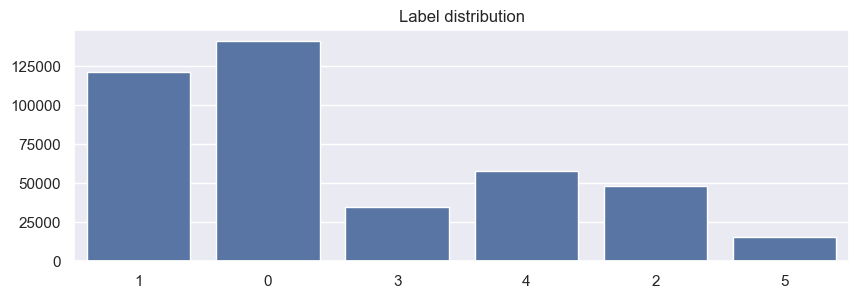

In [102]:
labels, label_counts = zip(*all_labels.most_common())
plt.figure(figsize=(10,3))
ax = sns.barplot(x=list(labels), y=list(label_counts))
ax.set_xticklabels(labels, rotation=0)
plt.title('Label distribution')
plt.show()

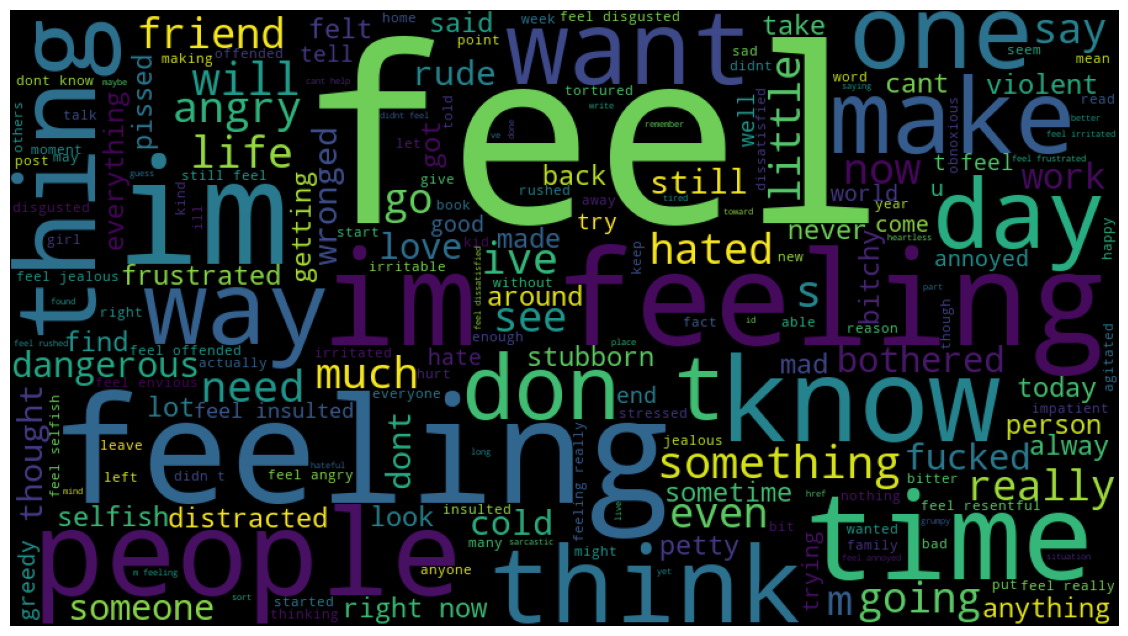

In [103]:
label = 3
plt.figure(figsize=(20,8))
subset = data_frame[data_frame.label == label]
text = subset.text.values 
cloud = WordCloud(stopwords=STOPWORDS, background_color='black', collocations=True,
                  width=900, height=500).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)


# Data Preprocessing

1. Remove stopwords

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
STOPWORDS = stopwords.words('english')

In [4]:
def clean_text(text, stopwords=STOPWORDS):
    # Lower 
    text = text.lower()
    
    # Remove stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords) + r')\b\s*')
    text = pattern.sub("", text)
    
    # Spacing and filters 
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)
    text = re.sub("[^A-Za-z0-9]+", " ", text)
    text = re.sub(" +", " ", text)
    text = re.sub("http\S+", "", text)
    
    return text

In [6]:
original_df = data_frame.copy()
data_frame.text = original_df.text.apply(clean_text)
data_frame.text.values[900]

NameError: name 'data_frame' is not defined

: 

Remove null values if exist

In [109]:
data_frame.isnull().value_counts()

text   label
False  False    416809
Name: count, dtype: int64

Tokenizer

In [110]:
import numpy as np
from transformers import BertTokenizer

In [111]:
def tokenize(batch_of_text):
    tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
    encoded_texts = tokenizer(batch_of_text['text'].tolist(), return_tensors='np', padding='longest')
    return dict(ids=encoded_texts["input_ids"], masks=encoded_texts['attention_mask'], targets=np.array(batch_of_text['label']))

In [112]:
tokenize(data_frame.head(1))

{'ids': array([[ 102, 7286, 9695, 2279, 2095, 6501, 2957,  119,  103]]),
 'masks': array([[1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'targets': array([4])}

Stemming

In [113]:
def stemmer(text):
    porter_stemmer = nltk.porter.PorterStemmer()
    text = ' '.join([porter_stemmer.stem(word) for word in text.split()])
    return text

In [114]:
data_frame['text'].apply(stemmer).head()

0                     feel realli helpless heavi heart
1    ive enjoy abl slouch relax unwind frankli need...
2                 gave internship dmrg feel distraught
3                                  dont know feel lost
4    kindergarten teacher thoroughli weari job take...
Name: text, dtype: object

In [115]:
def preprocess(df):
    df["text"] = df['text'].apply(clean_text)  
    df['text'] = df['text'].apply(stemmer)
    outputs = tokenize(df)
    return outputs

In [116]:
import ray

In [117]:
if ray.is_initialized():
    ray.shutdown()
ray.init()

2025-02-15 22:38:35,591	INFO worker.py:1841 -- Started a local Ray instance.


Python version:,3.10.11
Ray version:,2.42.1


In [118]:
ray.cluster_resources()

{'accelerator_type:G': 1.0,
 'node:__internal_head__': 1.0,
 'CPU': 12.0,
 'memory': 1413911348.0,
 'node:127.0.0.1': 1.0,
 'object_store_memory': 706955673.0,
 'GPU': 1.0}

In [119]:
ray.data.DatasetContext.get_current().execution_options.preserve_order = True

In [120]:
from ray.data import Dataset
from typing import Tuple, List, Dict

In [121]:
def stratify_split(
    ds: Dataset,
    stratify: str,
    test_size: float,
    shuffle: bool = True,
    seed: int = 1234,
) -> Tuple[Dataset, Dataset]:

    def _add_split(df: pd.DataFrame) -> pd.DataFrame:  # pragma: no cover, used in parent function
        train, test = train_test_split(df, test_size=test_size, shuffle=shuffle, random_state=seed)
        train["_split"] = "train"
        test["_split"] = "test"
        return pd.concat([train, test])

    def _filter_split(df: pd.DataFrame, split: str) -> pd.DataFrame:  # pragma: no cover, used in parent function
        """Filter by data points that match the split column's value
        and return the dataframe with the _split column dropped."""
        return df[df["_split"] == split].drop("_split", axis=1)

    # Train, test split with stratify
    grouped = ds.groupby(stratify).map_groups(_add_split, batch_format="pandas")  # group by each unique value in the column we want to stratify on
    train_ds = grouped.map_batches(_filter_split, fn_kwargs={"split": "train"}, batch_format="pandas")  # combine
    test_ds = grouped.map_batches(_filter_split, fn_kwargs={"split": "test"}, batch_format="pandas")  # combine

    # Shuffle each split (required)
    train_ds = train_ds.random_shuffle(seed=seed)
    test_ds = test_ds.random_shuffle(seed=seed)

    return train_ds, test_ds

In [122]:
ds = ray.data.read_csv("../datasets/text.csv")
ds = ds.random_shuffle(seed=42)

In [123]:
# Split dataset
test_size = 0.2
train_ds, val_ds = stratify_split(ds, stratify="label", test_size=test_size)

In [124]:
sample_ds = train_ds.map_batches(
    preprocess,
    batch_format="pandas"
)
sample_ds.show(1)

2025-02-15 22:38:40,770	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in C:\Users\admin\AppData\Local\Temp\ray\session_2025-02-15_22-38-31_816437_13772\logs\ray-data
2025-02-15 22:38:40,772	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> AllToAllOperator[RandomShuffle] -> AllToAllOperator[Sort] -> AllToAllOperator[MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]


Running 0: 0.00 row [00:00, ? row/s]

- ReadCSV->SplitBlocks(42) 1: 0.00 row [00:00, ? row/s]

- RandomShuffle 2: 0.00 row [00:00, ? row/s]

Shuffle Map 3:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 4:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Sort 5: 0.00 row [00:00, ? row/s]

Sort Sample 6:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Map 7:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 8:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(_add_split)->MapBatches(_filter_split)->RandomShuffle 9: 0.00 row [00:00, ? row/s]

Shuffle Map 10:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Shuffle Reduce 11:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(preprocess) 12: 0.00 row [00:00, ? row/s]

- limit=1 13: 0.00 row [00:00, ? row/s]

(map pid=6896) None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


{'ids': array([  102,  7286, 28621,   464, 17825,   599,   110, 15158,  1764,
         103,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0]), 'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'targets': 1}
